In [3]:
import torch
import torch.nn as nn

class TinyConvNet(nn.Module):
    def __init__(self):
        super(TinyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 30 * 30, 4)  # Assuming input image size is 480x480 after pooling

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output of conv layers
        x = self.fc(x)
        return x

# Example usage
# Initialize the network
net = TinyConvNet()
print(sum(p.numel() for p in net.parameters())/1e6, 'M parameters')

# Example input tensor (batch_size, channels, height, width)
input_tensor = torch.randn(1, 3, 120, 120)

# Forward pass
output = net(input_tensor)
print("Output shape:", output.shape)  # Output shape should be (batch_size, 4)


0.120292 M parameters
Output shape: torch.Size([1, 4])


In [1]:
import torch
import torch.nn as nn
import math

class CustomLoss(nn.Module):
    def __init__(self, T, C, D, E):
        super(CustomLoss, self).__init__()
        self.criterion = nn.MSELoss()
        self.T = T
        self.C = C
        self.D = D
        self.E = E

    def forward(self, action_predicted, action_ground_truth, x_des, x_t, t):
        t = t / self.T
        loss_torques = self.criterion(action_predicted, action_ground_truth)
        
        # loss_latent = self.C * self.criterion(x_des, x_t)
        # exp = math.exp(self.D * (t - (self.T / self.T)))
        # loss_latent *= exp
        # x_des = x_des[:, :2] # (batch_size, 2)
        # x_t = x_t[:, :2] # (batch_size, 2)

        rescale_vector = torch.tensor([1, 1, 0.0, 0.0], dtype=torch.float64)
        # print(x_des.shape)
        x_des *= rescale_vector
        x_t *= rescale_vector
        # print(x_des.shape)

        mse_latent = torch.mean((x_des - x_t).pow(2), dim=1) #(batch_size, 1)
        exp = torch.exp(self.D * (t - self.E)) #(batch_size, 1)
        scalar = self.C * exp
        scaled_mse_latent = scalar * mse_latent
        average_scaled_mse_latent = torch.mean(scaled_mse_latent) #(1, 1)

        return loss_torques + average_scaled_mse_latent, loss_torques
    
    
T = 49 
C = 1
D = 5
E = 1

criterion = CustomLoss(T, C, D, E)

batch_size = 10
act_pred = torch.randn(batch_size, 2)
act_truth = torch.randn(batch_size, 2)
x_des = torch.randn(batch_size, 4)
x_t = torch.randn(batch_size, 4)
t = torch.randint(low=0, high=50, size=(batch_size, ))
print("t", t.shape)
loss_custom, loss_torques = criterion(act_pred, act_truth, x_des, x_t, t)

t torch.Size([10])
torch.Size([10, 4])
torch.Size([10, 4])


In [15]:
# 2.0244 * 0.0345
0.8227 * 0.0152

0.01250504

In [4]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, inp_dim, enc_dim, out_dim):
        super().__init__()
        # super(MLP, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(inp_dim, enc_dim),
            nn.ReLU(True),
            nn.Linear(enc_dim, enc_dim),
            nn.ReLU(True),
            nn.Linear(enc_dim, out_dim),
            # nn.Tanh()
            # nn.ReLU(True),
            # nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.linear(x)
        return x


class GeneralModel(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        # super(GeneralModel, self).__init__()

        # self.alexnet = AlexNetPT(encoded_space_dim)
        # self.enc = Encoder(encoded_space_dim)
        # self.enc = TinyConvNet(encoded_space_dim)
        self.enc = MLP(2, 64, encoded_space_dim)

        # self.mlp_state = MLP(4, 128, encoded_space_dim)
        self.mlp_controller = MLP(encoded_space_dim, 128, 2)
        # Set the bias of the last linear layer to 0
        self.mlp_controller.linear[2].bias.data.fill_(0.0)

    def forward(self, target_pos, state):
        # x = self.mlp_state(state)
        x = state

        # x_des = self.alexnet(img_tensor)
        x_des = self.enc(target_pos)
        
        print("x_des", x_des.shape)
        x_des = torch.squeeze(x_des, 0) # (1, encoded_space_dim)
        print("x_des", x_des.shape)
        diff = x_des - x
        print("diff", diff.shape)

        acts_pred = F.tanh(self.mlp_controller(diff))

        return acts_pred, x_des, diff


batch_size = 10
target_pos = torch.randn(batch_size, 2)
state = torch.randn(batch_size, 4)

model = GeneralModel(4)
act_pred, x_des, diff = model(target_pos, state)


x_des torch.Size([10, 4])
x_des torch.Size([10, 4])
diff torch.Size([10, 4])


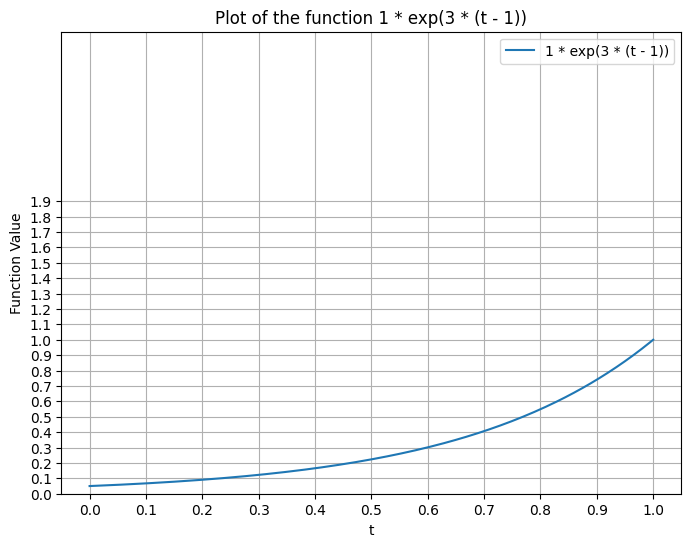

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Constants
C = 1 #10 #5  # You can change the value of C as per your requirement
D = 3 #5 #10 # You can change the value of D as per your requirement
E = 1

# Define the function
def custom_function(t):
    return C * np.exp(D * (t - E))

# Generate values for t in the range [0, 1]
t_values = np.linspace(0, 1, 200)  # 1000 points between 0 and 1

# Calculate corresponding function values
function_values = custom_function(t_values)

# Plot the function
plt.figure(figsize=(8, 6))
plt.plot(t_values, function_values, label=f'{C} * exp({D} * (t - {E}))')
plt.xlabel('t')
plt.ylabel('Function Value')
plt.title(f'Plot of the function {C} * exp({D} * (t - {E}))')
plt.legend()

plt.xticks(np.arange(0, 1.1, 0.1))  # Set x-axis grid at every integer from 0 to 1
plt.yticks(np.trajsarange(0, 2, 0.1))  # Set y-axis grid at every integer from 0 to 10
plt.ylim(0, 3)

plt.grid(True)
plt.savefig(os.path.join(os.getcwd(), "tmp_result/loss.png"))
plt.show()


In [10]:
print(custom_function(49/49))
print(custom_function(20/200))

1.0
0.011108996538242306


In [10]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader

class TrajectoryDataset(Dataset):
    def __init__(self, data_root_dir, file_adr, transform=None):
        self.trajectories = np.load(data_root_dir + file_adr)
        print(self.trajectories.shape)
        self.data_root_dir = data_root_dir
        self.transform = transform

    def __len__(self):
        return 1000 * 50
        # return 70*49

    def __getitem__(self, idx):
        traj_no = idx // 50
        step_no = idx % 50

        step = self.trajectories[traj_no, step_no, 0]
        state = self.trajectories[traj_no, step_no, 1:5]
        target_pos = self.trajectories[traj_no, step_no, 5:7]
        action = self.trajectories[traj_no, step_no, 7:]

        # image = Image.open(self.data_root_dir + f"/scene_images/goal_{traj_no}.png")
        # if self.transform:
        #     image = self.transform(image)

        return step, state, target_pos, action
    

# transform = transforms.Compose([
#                 transforms.Resize([120, 120]),
#                 # transforms.RandomHorizontalFlip(), # Flip the data horizontally
#                 transforms.ToTensor(),
#                 # transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
#             ])
dir_name = "."#os.path.dirname(__file__)
dataset_name = "1K_cartesian_w_step"
batch_size = 32
dataset = TrajectoryDataset(dir_name + f'/data/{dataset_name}/0', '/trajectories_normalized.npy')
train_set, val_set = torch.utils.data.random_split(dataset, [0.9, 0.1])
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

(1000, 50, 9)


In [4]:
import torch

batch_size = 3
act_pred = torch.randn(batch_size, 4)
rescale_vector = torch.tensor([1, 1, 0.1, 0.1], dtype=torch.float32)
print(act_pred)
act_pred*rescale_vector

tensor([[-1.3480, -0.5244,  1.5999,  0.9089],
        [-1.8859,  0.5702,  1.4260,  0.7666],
        [-0.2379,  0.3068, -1.3214, -1.3079]])


tensor([[-1.3480, -0.5244,  0.1600,  0.0909],
        [-1.8859,  0.5702,  0.1426,  0.0767],
        [-0.2379,  0.3068, -0.1321, -0.1308]])

In [2]:
import numpy as np

num_params = ["0.27", "0.57", "1.846"]
num_params_base = ["0.269", "0.575", "1.806"]

for i in range(len(num_params)):
    n_p = num_params[i]
    n_p_b = num_params_base[i]

    results_root_path = "./test_results/466_man_tra|cus_los_5_10_1|st_vel_norm"
    results_root_path += f"|tar_cart|{n_p}K_params|epoch_1200"

    loss_torques_value_trains = np.load(results_root_path + \
                                                    "/loss_torques_value_trains.npy")
    
    break

In [5]:
loss_torques_value_trains/100

array([[1.75161045, 1.7237823 , 1.68088485, 1.69851039, 2.00452566],
       [1.36258173, 1.39338349, 1.28268452, 1.33953193, 1.62887984],
       [1.16691254, 1.37057928, 1.1099989 , 1.22319595, 1.24395918],
       [0.66343274, 0.63163631, 0.56455241, 0.69700024, 0.79249429],
       [0.61742273, 0.71223477, 0.43436044, 0.81787861, 0.79718367]])

In [29]:
import numpy as np 
import math

def get_line_equation(x1, y1, x2, y2):
    # Calculate the slope
    slope = (y2 - y1) / ((x2 - x1)+1e-10) 
    # Calculate the y-intercept (b) using one of the points
    b = y1 - slope * x1

    return slope, b

In [36]:
s, b = get_line_equation(1, 1, 2, 2)
alpha = np.arctan(s)
alpha = np.arctan()
d = 0.001
x = 0.10
y = 0.10
print(y+d*np.sin(alpha))
print(x+d*np.cos(alpha))
print(alpha)

TypeError: arctan2() takes from 2 to 3 positional arguments but 1 were given

In [34]:
s, b = get_line_equation(0, 1, 0, 2)
alpha = np.arctan(s)
d = 0.001
x = 0.10
y = 0.10
print(y+d*np.sin(alpha))
print(x+d*np.cos(alpha))
print(alpha)

0.101
0.10000000000010001
1.5707963266948965


In [35]:
s, b = get_line_equation(-2, 2, -1, 1)
alpha = np.arctan(s)
d = 0.001
x = 0.10
y = 0.10
print(y+d*np.sin(alpha))
print(x+d*np.cos(alpha))
print(alpha)

0.09929289321884881
0.10070710678122191
-0.7853981633474483


s (4.148937818729735, -7.5152554883358675) e (4.911527792338497, 8.819361184962315)
(0.04663472049842385, 0.9989120095604185) 0.9999999999999997
(0.046634720498423834, 0.9989120095604186) 0.9999999999999999
(0.046634720498423814, 0.9989120095604187) 1.0
(0.046634720498423786, 0.9989120095604186) 0.9999999999999999
(0.046634720498423765, 0.9989120095604187) 1.0
(0.04663472049842374, 0.9989120095604186) 0.9999999999999999
(0.04663472049842371, 0.9989120095604187) 1.0
(0.04663472049842367, 0.9989120095604186) 0.9999999999999999
(0.04663472049842364, 0.9989120095604187) 1.0
(0.04663472049842368, 0.9989120095604187) 1.0


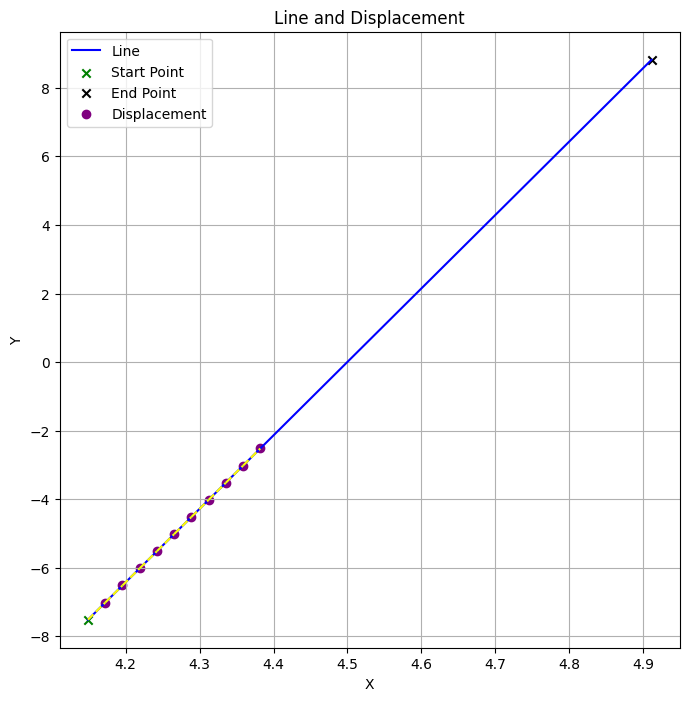

In [83]:
import random
import math
import matplotlib.pyplot as plt

# Function to calculate distance between two points
def distance(point1, point2):
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

# Function to calculate unit vector
def unit_vector(point1, point2):
    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    length = distance(point1, point2)
    return (dx/length, dy/length)

# Function to displace along the line between two points
def displace_along_line(start_point, end_point, epsilon):
    unit_vec = unit_vector(start_point, end_point)
    print(unit_vec, unit_vec[0]**2 + unit_vec[1]**2)
    displacement = (unit_vec[0] * epsilon, unit_vec[1] * epsilon)
    return (start_point[0] + displacement[0], start_point[1] + displacement[1])

# Generate random start and end points
start_point = (random.uniform(-10, 10), random.uniform(-10, 10))
end_point = (random.uniform(-10, 10), random.uniform(-10, 10))

# Set epsilon (displacement amount)
epsilon = 0.5

# Number of iterations
iterations = 10

# Plotting
plt.figure(figsize=(8, 8))
plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'b-', label='Line')
# plt.plot([start_point[0], start_point[1]], [end_point[0], end_point[1]], 'b-', label='Line')
plt.scatter(start_point[0], start_point[1], color='green', marker='x', label='Start Point')
plt.scatter(end_point[0], end_point[1], color='black', marker='x', label='End Point')

# Iterate and displace along the line
print("s", start_point, "e", end_point)
for i in range(iterations):
    new_point = displace_along_line(start_point, end_point, epsilon)
    plt.scatter(new_point[0], new_point[1], color='purple', label='Displacement' if i == 0 else None)
    plt.plot([start_point[0], new_point[0]], [start_point[1], new_point[1]], 
             color='yellow', linestyle='--')
    # print("Iteration:", i+1, "New point:", new_point)
    # Update start_point for next iteration
    start_point = new_point

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Line and Displacement')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
import numpy as np

def displacement(start_point, end_point, epsilon):
    # Convert points to numpy arrays for easier computation
    start_point = np.array(start_point)
    end_point = np.array(end_point)
    
    # Calculate the vector representing the direction from start_point to end_point
    direction_vector = end_point - start_point
    
    # Calculate the unit vector in the direction of the line
    unit_vector = direction_vector / np.linalg.norm(direction_vector)
    print("###", unit_vector)
    
    # Initialize current position as start_point
    current_position = start_point.copy()
    
    # Iterate and displace epsilon amount towards end_point
    while np.linalg.norm(current_position - end_point) >= epsilon:
        # Move epsilon distance towards end_point along the direction vector
        current_position += epsilon * unit_vector
        yield tuple(current_position)

# Example usage:
start_point = (1.0, 1.0)
end_point = (5, 7)
epsilon = 0.5

# Iterate over the displaced points
for point in displacement(start_point, end_point, epsilon):
    print(point)


### [0.5547002  0.83205029]
(1.2773500981126147, 1.4160251471689218)
(1.5547001962252294, 1.8320502943378436)
(1.832050294337844, 2.2480754415067654)
(2.1094003924504587, 2.664100588675687)
(2.3867504905630734, 3.080125735844609)
(2.664100588675688, 3.496150883013531)
(2.941450686788303, 3.9121760301824526)
(3.2188007849009175, 4.328201177351374)
(3.496150883013532, 4.744226324520296)
(3.773500981126147, 5.160251471689218)
(4.050851079238761, 5.57627661885814)
(4.328201177351375, 5.992301766027062)
(4.60555127546399, 6.4083269131959835)
(4.882901373576604, 6.824352060364905)


In [1]:
import numpy as np

In [4]:
array = np.load('./data/obs_final.npy', allow_pickle=True, encoding='latin1')
array.shape

(815, 50, 3, 1)

In [6]:
array[0][0]

array([[0],
       [array([0.95378724, 0.24798383, 0.99937049, 1.35779412, 0.79928581,
               0.13905992, 0.12295033])                                   ],
       [array([ 0.        ,  0.        ,  0.34413712,  0.39380216,  1.3167559 ,
                1.71655127, -1.5071147 , -1.30665576,  1.13387109,  0.        ])]],
      dtype=object)

In [6]:
import torch

# Sample tensors tensor_a and tensor_b of size 32x7
tensor_a = torch.randn(32, 7)
tensor_b = torch.randn(32, 7)

# Compute the absolute difference
abs_diff = torch.abs(tensor_a - tensor_b)
print(abs_diff.shape)

# Compute the mean of the absolute differences along dimension 0 (rows)
result = torch.mean(abs_diff, dim=0)

print(result.shape)


torch.Size([32, 7])
torch.Size([7])


In [8]:
print(result.size())

torch.Size([7])


In [9]:
result

tensor([1.0217, 1.0456, 1.1665, 1.2228, 1.0123, 1.1400, 1.2556])

In [11]:
result[1].item()

1.045613408088684

In [30]:
import pickle
import numpy as np

with open('./weights/815_trajs_static|cus_los_5_10_1|tar_cart|45.333K_params/train_no_0/info.pickle', 'rb') as handle:
    train_info = pickle.load(handle)

In [31]:
train_info

{'mae_joint_1_val': [0.26852163672447205,
  0.033704765141010284,
  0.016566550359129906,
  0.01693328656256199,
  0.014870665036141872,
  0.008178610354661942,
  0.011552088893949986,
  0.016923733055591583,
  0.00878257118165493,
  0.012893233448266983,
  0.012214136309921741,
  0.010287226177752018,
  0.01214129664003849,
  0.01658087782561779,
  0.010347940027713776,
  0.01154912170022726,
  0.01319499034434557,
  0.01335305068641901,
  0.015974802896380424,
  0.016094140708446503,
  0.014884638600051403,
  0.015091034583747387,
  0.011653183959424496,
  0.014001808129251003,
  0.013740289025008678,
  0.009688280522823334,
  0.01099972054362297,
  0.010429061017930508,
  0.007617153227329254,
  0.012672141194343567,
  0.00930751021951437,
  0.009840307757258415,
  0.018065501004457474,
  0.009812978096306324,
  0.011294678784906864,
  0.008895433507859707,
  0.011843254789710045,
  0.008137794211506844,
  0.014961645007133484,
  0.007366584148257971,
  0.010310426354408264,
  0.014

In [32]:
train_info.keys()

dict_keys(['mae_joint_1_val', 'mae_joint_1_train', 'mae_joint_2_val', 'mae_joint_2_train', 'mae_joint_3_val', 'mae_joint_3_train', 'mae_joint_4_val', 'mae_joint_4_train', 'mae_joint_5_val', 'mae_joint_5_train', 'mae_joint_6_val', 'mae_joint_6_train', 'mae_joint_7_val', 'mae_joint_7_train'])

In [33]:
train_info_arr = dict()

for key in train_info.keys():
    train_info_arr[key] = np.array(train_info[key])

train_info_arr

{'mae_joint_1_val': array([0.26852164, 0.03370477, 0.01656655, 0.01693329, 0.01487067,
        0.00817861, 0.01155209, 0.01692373, 0.00878257, 0.01289323,
        0.01221414, 0.01028723, 0.0121413 , 0.01658088, 0.01034794,
        0.01154912, 0.01319499, 0.01335305, 0.0159748 , 0.01609414,
        0.01488464, 0.01509103, 0.01165318, 0.01400181, 0.01374029,
        0.00968828, 0.01099972, 0.01042906, 0.00761715, 0.01267214,
        0.00930751, 0.00984031, 0.0180655 , 0.00981298, 0.01129468,
        0.00889543, 0.01184325, 0.00813779, 0.01496165, 0.00736658,
        0.01031043, 0.01431649, 0.00781184, 0.01258093, 0.01881928,
        0.00870366]),
 'mae_joint_1_train': array([0.04520487, 0.03014515, 0.03480316, 0.01309841, 0.00887334,
        0.04766358, 0.0359029 , 0.02020187, 0.06449114, 0.05648756,
        0.02453699, 0.0385267 , 0.00427132, 0.00310702, 0.01227881,
        0.01367006, 0.03701191, 0.00836536, 0.01965318, 0.00472127,
        0.01259762, 0.01662738, 0.04713337, 0.01560454

In [35]:
train_info_mean = dict()

for key in train_info_arr.keys():
    train_info_mean[key] = np.mean(train_info_arr[key])

train_info_mean

{'mae_joint_1_val': 0.018337181445373142,
 'mae_joint_1_train': 0.021108174349905716,
 'mae_joint_2_val': 0.007955079199746251,
 'mae_joint_2_train': 0.009422145423013718,
 'mae_joint_3_val': 0.01612037877835657,
 'mae_joint_3_train': 0.013859687477815897,
 'mae_joint_4_val': 0.008743108336246856,
 'mae_joint_4_train': 0.012098317412245605,
 'mae_joint_5_val': 0.025308088561438995,
 'mae_joint_5_train': 0.03447267569394575,
 'mae_joint_6_val': 0.014614870265612135,
 'mae_joint_6_train': 0.014495025970973074,
 'mae_joint_7_val': 0.029496488950984633,
 'mae_joint_7_train': 0.03419100446626544}

In [36]:
train_info_std = dict()

for key in train_info_arr.keys():
    train_info_std[key] = np.std(train_info_arr[key])

train_info_std

{'mae_joint_1_val': 0.03754395507536457,
 'mae_joint_1_train': 0.01560763831058418,
 'mae_joint_2_val': 0.013561544752963431,
 'mae_joint_2_train': 0.008202291331875416,
 'mae_joint_3_val': 0.0387554047604528,
 'mae_joint_3_train': 0.013164492728275195,
 'mae_joint_4_val': 0.01380285869595092,
 'mae_joint_4_train': 0.011066740775993855,
 'mae_joint_5_val': 0.04615559483225237,
 'mae_joint_5_train': 0.024556944211123515,
 'mae_joint_6_val': 0.03829716383987713,
 'mae_joint_6_train': 0.011598280019879476,
 'mae_joint_7_val': 0.06223933058506731,
 'mae_joint_7_train': 0.024851619075394075}

In [37]:
train_info_min = dict()

for key in train_info_arr.keys():
    train_info_min[key] = np.min(train_info_arr[key])

train_info_min

{'mae_joint_1_val': 0.007366584148257971,
 'mae_joint_1_train': 0.002003511181101203,
 'mae_joint_2_val': 0.0025194110348820686,
 'mae_joint_2_train': 0.0009729603189043701,
 'mae_joint_3_val': 0.004206615500152111,
 'mae_joint_3_train': 0.0006856404361315072,
 'mae_joint_4_val': 0.002946537220850587,
 'mae_joint_4_train': 0.0013575031189247966,
 'mae_joint_5_val': 0.008953646756708622,
 'mae_joint_5_train': 0.0017449511215090752,
 'mae_joint_6_val': 0.004534616135060787,
 'mae_joint_6_train': 0.0018645523814484477,
 'mae_joint_7_val': 0.00881557073444128,
 'mae_joint_7_train': 0.003577054711058736}

In [38]:
train_info_max = dict()

for key in train_info_arr.keys():
    train_info_max[key] = np.max(train_info_arr[key])

train_info_max

{'mae_joint_1_val': 0.26852163672447205,
 'mae_joint_1_train': 0.0644911378622055,
 'mae_joint_2_val': 0.09743509441614151,
 'mae_joint_2_train': 0.03453132510185242,
 'mae_joint_3_val': 0.2722736597061157,
 'mae_joint_3_train': 0.053722456097602844,
 'mae_joint_4_val': 0.0979306772351265,
 'mae_joint_4_train': 0.046930622309446335,
 'mae_joint_5_val': 0.33261623978614807,
 'mae_joint_5_train': 0.09976851940155029,
 'mae_joint_6_val': 0.2703743278980255,
 'mae_joint_6_train': 0.044287342578172684,
 'mae_joint_7_val': 0.44526407122612,
 'mae_joint_7_train': 0.1012720838189125}

In [1]:
!pwd

/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network


In [4]:
import numpy as np
import os

ds_root_dir = "data/torobo/trajs:360_blocks:3_triangle_v"
file_name = "train_ds.npy"
data_file_path = os.path.join(ds_root_dir, file_name)
trajectories = np.load(data_file_path)#[0:4]
print("trajectories.shape", trajectories.shape)

trajectories.shape (360, 299, 35)


In [25]:
data1 = trajectories[:, 0, 15:18]
print(data1.shape)
data2 = trajectories[:, 0, 18:21]
print(data2.shape)
data3 = trajectories[:, 0, 21:24]
print(data3.shape)

(360, 3)
(360, 3)
(360, 3)


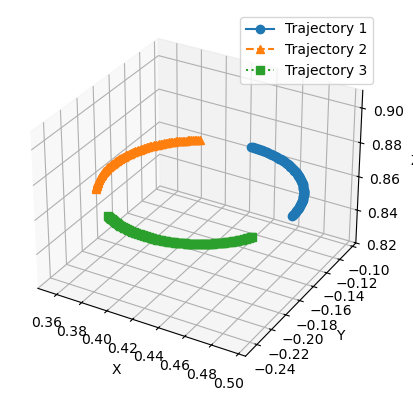

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

idx = 90
# Extract x, y, z coordinates for all datasets
x1, y1, z1 = data1[:idx, 0], data1[:idx, 1], data1[:idx, 2]
x2, y2, z2 = data2[:idx, 0], data2[:idx, 1], data2[:idx, 2]
x3, y3, z3 = data3[:idx, 0], data3[:idx, 1], data3[:idx, 2]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the first trajectory
ax.plot(x1, y1, z1, label='Trajectory 1', linestyle='-', marker='o')

# Plot the second trajectory
ax.plot(x2, y2, z2, label='Trajectory 2', linestyle='--', marker='^')

# Plot the third trajectory
ax.plot(x3, y3, z3, label='Trajectory 3', linestyle=':', marker='s')

# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Show the plot
plt.show()


In [32]:
print(data1[:, 0].min(), data1[:, 1].min(), data1[:, 2].min())

0.355 -0.245 0.865


In [33]:
print(data2[:, 0].min(), data2[:, 1].min(), data2[:, 2].min())

0.355 -0.245 0.865
